In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import pickle


In [2]:
df = pd.read_csv('../../data/FimaNfipClaims.csv')

In [3]:
#see which years have data: 
agg= df.groupby('yearOfLoss').agg({'amountPaidOnBuildingClaim':'count'})
print(agg.head(10))
#crop to after 1975 
df = df.loc[df['yearOfLoss']>=1975]

            amountPaidOnBuildingClaim
yearOfLoss                           
1970                                0
1972                                0
1973                                3
1974                                4
1975                               20
1976                               36
1977                             3503
1978                            25352
1979                            61512
1980                            36459


In [4]:
#remove certain states due to highly missing data 
rm = ['GU', np.nan, 'AS','MP','UN']
df = df[~df['state'].isin(rm)]

<AxesSubplot:title={'center':'Annual Total Claim Payment to Buildings in US'}, xlabel='yearOfLoss'>

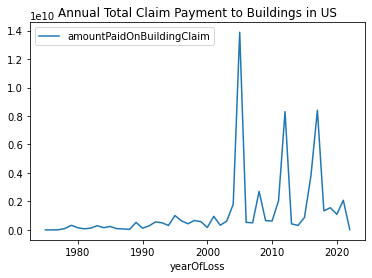

In [5]:
df.groupby('yearOfLoss').agg({'amountPaidOnBuildingClaim':'sum'})\
.plot(title='Annual Total Claim Payment to Buildings in US')

<AxesSubplot:title={'center':'Top 15 highest paying states in US'}, xlabel='state'>

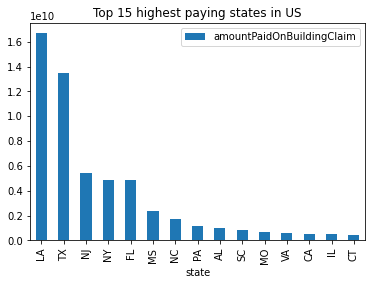

In [6]:
#aggregate by state 
# df.groupby('state').agg({'amountPaidOnBuildingClaim':'sum'}).plot()
# df_22 = df.loc[df['yearOfLoss']==2022]
df.groupby('state').agg({'amountPaidOnBuildingClaim':'sum'})\
.sort_values(by='amountPaidOnBuildingClaim', ascending=False)\
.head(15).plot(kind='bar', title='Top 15 highest paying states in US')



<AxesSubplot:xlabel='yearOfLoss'>

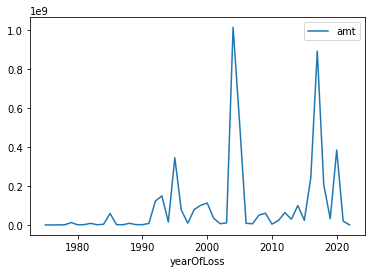

In [7]:
#compute cma for each state
state='FL'

#aggregate annual loss for one state 
def agg_state(df, state = 'FL'): 
    df1 = df.loc[df['state']==state]
    #compute annual loss for each state 
    df1 = df1.groupby('yearOfLoss').agg({'amountPaidOnBuildingClaim':'sum'}).sort_values(by='amountPaidOnBuildingClaim')\
    .rename(columns={'amountPaidOnBuildingClaim':'amt'}).sort_values(by='yearOfLoss')
    return df1 

agg1 = agg_state(df, state)
agg1.plot()

In [8]:
#interpolate yearly index, set missing years=0 

def yr_index(agg1):
    #min, max years to be 1975 and 2022  
    min_y, max_y = 1975, 2022 
    #set index to be yr id: interpolate missing years 
    yid = np.arange(min_y, max_y+1, 1)
    yid = pd.DataFrame(yid, columns=['year'])

    #merge with new index 
    agg1_out = pd.merge(yid, agg1, left_on='year', right_on = 'yearOfLoss', how='left')
    #count missing years for this state 
    miss = agg1_out.amt.isnull().sum() 
    if miss > 0: 
        print('num of missing years', miss)
    #fillna with 0 
    agg1_out = agg1_out.fillna(0)
    
    return agg1_out

agg1 = yr_index(agg1)


num of missing years 1


In [9]:
#compute cma or sma 
def compute_cma(df, state='FL'):  
    agg1 = agg_state(df, state)
    agg1 = yr_index(agg1) 
    
    #compute cma for one state 
    agg1['cma'] = agg1['amt'].expanding().mean()
    #compute sma for one state 
    agg1['sma'] = agg1['amt'].rolling(window=10).mean()
    
    #set premium cma for next year to be the cma of current year 
    agg1['p_cma'] = agg1.cma.shift(1) #altnernatively could use agg1.sma.shift(1)
    #set premium cma for next year to be the cma of current year 
    agg1['p_sma'] = agg1.sma.shift(1) #altnernatively could use agg1.sma.shift(1)
    
    #compute balance: cumsum of premium - cumsum of loss 
    agg1['balance_cma'] = agg1.p_cma.cumsum()-agg1.amt.cumsum()
    agg1['balance_sma'] = agg1.p_sma.cumsum()-agg1.amt.cumsum()
    
    return agg1 


num of missing years 1


Text(0.5, 1.0, 'total amt, cma, and balance for LA state')

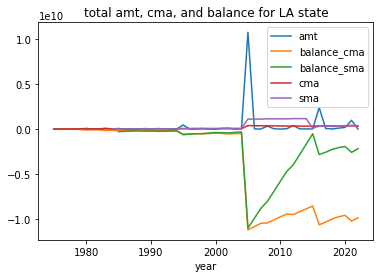

In [10]:
#compute cma for one state 
agg1_cma = compute_cma(df, 'LA')
for col in ['amt','balance_cma','balance_sma','cma','sma']: 
    agg1_cma.set_index('year')[col].plot(label=col)
plt.legend()
plt.title('total amt, cma, and balance for LA state')

In [11]:
#do this for all states 
state_ls = df.state.unique()
print(len(state_ls)) #the number of states is not correct 

53


In [12]:
base = {}
for state in state_ls:
    #remove certain states due to high missing data 
    if state not in rm: 
        print(state)
        base[state] = compute_cma(df, state)

MD
MT
num of missing years 4
TX
FL
num of missing years 1
SC
num of missing years 1
VA
num of missing years 1
MI
NC
num of missing years 1
NJ
OH
num of missing years 2
IL
num of missing years 1
LA
num of missing years 1
MO
num of missing years 1
AZ
num of missing years 2
DE
num of missing years 1
PA
NY
CT
num of missing years 1
GA
num of missing years 1
CA
num of missing years 1
MS
num of missing years 2
IA
num of missing years 4
UT
num of missing years 3
MN
MA
num of missing years 2
AL
num of missing years 1
KS
num of missing years 3
SD
num of missing years 3
AR
num of missing years 2
WV
num of missing years 2
RI
num of missing years 2
WA
num of missing years 1
OK
num of missing years 2
OR
num of missing years 2
HI
num of missing years 1
ID
num of missing years 5
TN
num of missing years 1
CO
num of missing years 2
IN
num of missing years 2
KY
num of missing years 2
ND
num of missing years 1
WI
num of missing years 1
NE
num of missing years 3
NH
num of missing years 2
NM
num of missing

Text(0.5, 1.0, 'balance status for most flooded states')

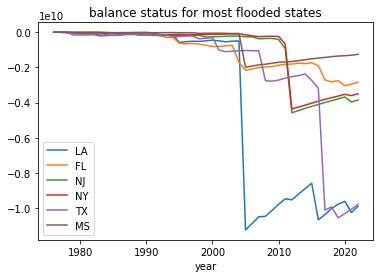

In [13]:
#plot balance over flooding states 
for state in ['LA','FL','NJ','NY','TX','MS']:
    base[state].set_index('year')['balance_cma'].plot(label=state)
plt.legend()
plt.title('balance status for most flooded states')

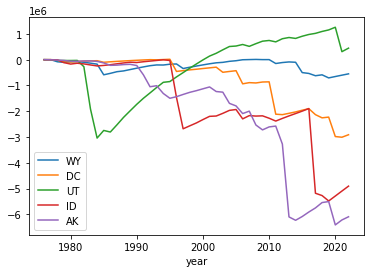

In [14]:
#plot balance over LEAST flooded states 
for state in ['WY','DC','UT','ID','AK']:
    base[state].set_index('year')['balance_cma'].plot(label=state)
plt.legend()

In [15]:
#total loss over all states 
total_cma, total_sma=0,0
for state in state_ls:
    total_cma += base[state]['balance_cma'].iloc[-1]
    total_sma += base[state]['balance_sma'].iloc[-1]
print(total_cma, total_sma)

-37834031719.413475 -11120235548.924


Text(0.5, 1.0, 'CMA for most flooded states')

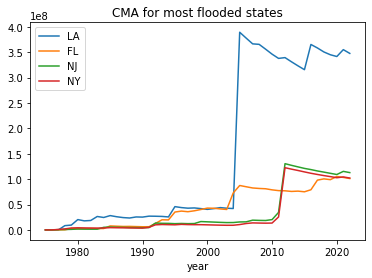

In [16]:
#look at premium for a state 
for state in ['LA','FL','NJ','NY']:
    base[state].set_index('year')['cma'].plot(label=state)
plt.legend()
plt.title('CMA for most flooded states')

Text(0.5, 1.0, 'SMA for most flooded states')

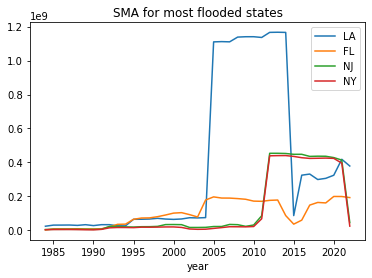

In [17]:
for state in ['LA','FL','NJ','NY']:
    base[state].set_index('year')['sma'].plot(label=state)
plt.legend()
plt.title('SMA for most flooded states')

In [23]:
# #save to pickle 
# with open('baseline_dict.pkl', 'wb') as handle:
#     pickle.dump(base, handle, protocol=pickle.HIGHEST_PROTOCOL)




In [54]:
# #save df to csv 
# #instead of percentile do this for loss levels:
# #append df from all states into one df 
# df_all = pd.DataFrame()
# for state in base:
#     df1= base[state]
#     df1['state'] = state 
#     df_all = pd.concat([df_all, df1], axis=0) 

# # df_all.to_csv('baseline_all.csv')

In [55]:
df_all

,year,amt,cma,sma,p_cma,p_sma,balance_cma,balance_sma,state
0,1975,17954.00,17954.000000,NaN,NaN,NaN,NaN,NaN,MD
1,1976,0.00,8977.000000,NaN,17954.000000,NaN,0.000000e+00,NaN,MD
2,1977,45148.24,21034.080000,NaN,8977.000000,NaN,-3.617124e+04,NaN,MD
3,1978,266875.31,82494.387500,NaN,21034.080000,NaN,-2.820125e+05,NaN,MD
4,1979,4207880.11,907571.532000,NaN,82494.387500,NaN,-4.407398e+06,NaN,MD
...,...,...,...,...,...,...,...,...,...
43,2018,16446.83,51010.715000,101446.978,51814.526279,102840.808,-5.876355e+05,-714180.457,WY
44,2019,170740.50,53671.376889,114182.721,51010.715000,101446.978,-7.073653e+05,-783473.979,WY
45,2020,0.00,52504.607826,110550.579,53671.376889,114182.721,-6.536939e+05,-669291.258,WY
46,2021,0.00,51387.488511,91831.231,52504.607826,110550.579,-6.011893e+05,-558740.679,WY


In [56]:
pd.pivot_table(df_all, values="amt", index="state", columns = "year")

year,1975,1976,1977,1978,1979,1980,1981,1982,1983,1984,...,2013,2014,2015,2016,2017,2018,2019,2020,2021,2022
state,,,,,,,,,,,,,,,,,,,,,
AK,0.00,0.00,5903.75,11716.46,1.761237e+04,36786.88,15580.51,1048.06,7.545490e+03,31442.74,...,2968448.02,346894.09,7.323237e+04,4.081931e+04,5.246003e+04,0.000000e+00,1.643211e+05,1.107622e+06,2.953595e+04,93942.35
AL,0.00,0.00,34784.86,256567.27,3.176053e+07,4422922.76,11248130.67,250377.10,2.793378e+06,120517.10,...,2443080.47,44492863.45,8.210449e+06,4.284602e+05,6.981425e+06,1.299315e+06,3.247320e+06,1.534390e+08,2.317838e+07,405466.57
AR,0.00,0.00,77.93,1394319.36,4.080412e+05,319408.03,291490.19,1438287.38,5.727776e+05,1191923.96,...,3103224.96,2017908.24,9.131053e+06,5.783676e+06,2.262333e+07,2.131067e+06,2.976318e+07,2.358116e+06,5.618149e+06,4168.56
AZ,0.00,0.00,50921.61,2557998.62,1.679542e+05,1954059.98,125128.74,81736.65,4.413731e+06,274302.05,...,978086.90,7239272.87,3.253915e+05,1.736556e+06,1.011870e+06,1.593298e+06,4.547871e+06,2.390135e+05,4.733966e+06,2068.31
CA,0.00,0.00,236663.52,3125469.95,1.562737e+06,10066831.32,1261012.55,10966297.13,2.455863e+07,544996.83,...,1096188.20,12987047.33,1.409402e+06,5.414700e+06,3.443189e+07,2.087612e+07,3.727762e+07,1.574860e+06,7.122618e+06,78977.48
CO,0.00,0.00,12750.75,151917.81,2.759888e+05,143309.69,107376.40,929264.94,4.691389e+05,452149.49,...,64786413.29,334102.68,1.737837e+06,1.235702e+05,5.644677e+04,5.244505e+05,3.446705e+05,1.557249e+05,5.758911e+05,0.00
CT,0.00,3743.00,32368.09,1007355.80,1.476092e+06,2859159.72,26377.36,5757730.28,5.708862e+05,3472974.89,...,379801.97,357123.54,4.136813e+04,4.277494e+04,2.775529e+05,8.991201e+06,5.881612e+05,3.354902e+05,3.311172e+07,36466.80
DC,0.00,0.00,0.00,21269.20,6.462033e+04,25977.96,756.66,0.00,4.669950e+03,7229.15,...,25908.41,22760.34,9.704140e+03,1.479333e+04,3.025749e+05,2.016427e+05,5.205572e+04,8.334975e+05,1.230728e+05,0.00
DE,0.00,0.00,47428.48,93388.68,3.843167e+04,169109.23,14794.46,11520.77,8.806552e+04,172262.78,...,249561.88,496820.47,1.462965e+05,1.304659e+06,6.181058e+04,3.785781e+05,1.063737e+05,1.918318e+06,7.691960e+06,6292.26


In [ ]:
pd.pivot_table(df_all, values="amt", index="state", columns = "year")

## Construct flood risk maps

In [27]:
#load pickle of baseline dictionarys 
with open('baseline_dict.pkl', 'rb') as handle:
    base2 = pickle.load(handle)

In [18]:
#count flood frequency 

,amountPaidOnBuildingClaim
count,4.600000e+01
mean,2.245211e+05
std,4.779071e+05
min,0.000000e+00
25%,1.399925e+04
50%,4.663967e+04
75%,2.679790e+05
max,2.968448e+06


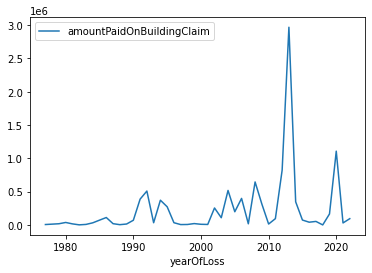

In [19]:
df.groupby(['state','yearOfLoss']).agg({'amountPaidOnBuildingClaim':'sum'}).loc['AK'].plot()

#protecting against certain percentile of floods 
df.groupby(['state','yearOfLoss']).agg({'amountPaidOnBuildingClaim':'sum'}).loc['AK'].describe()

Text(0.5, 1.0, '')

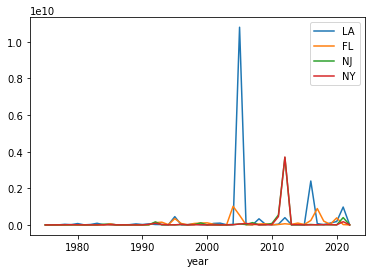

In [20]:
#plot flood amount over flooding states 
for state in ['LA','FL','NJ','NY']:
    base[state].set_index('year')['amt'].plot(label=state)
plt.legend()
plt.title('')

In [51]:
#count number of years over certain percentile flooding risks historically 
state_list = base.keys()
risk = pd.DataFrame(index = state_list, columns=q_list)

q_list = [0.25, 0.5, 0.75, 0.9] 

for state in state_list: 
    print(state)
    for q in q_list: 
#         print(state)
        #get one state amount 
        dff =base[state][['year','amt']] 

        #filter to years passing through threshold 
        q_amt = dff['amt'].quantile(q)

        #compute frequency of years passing through threshold  
        freq = dff.loc[dff['amt']>=q_amt].shape[0]/dff.shape[0]
        risk.loc[state][q] = freq
        print(freq)


#to do: 
#for percentile in range, compute the number of years for each state having certain percentile of losses 




MD
0.75
0.5
0.25
0.10416666666666667
MT
0.75
0.5
0.25
0.10416666666666667
TX
0.75
0.5
0.25
0.10416666666666667
FL
0.75
0.5
0.25
0.10416666666666667
SC
0.75
0.5
0.25
0.10416666666666667
VA
0.75
0.5
0.25
0.10416666666666667
MI
0.75
0.5
0.25
0.10416666666666667
NC
0.75
0.5
0.25
0.10416666666666667
NJ
0.75
0.5
0.25
0.10416666666666667
OH
0.75
0.5
0.25
0.10416666666666667
IL
0.75
0.5
0.25
0.10416666666666667
LA
0.75
0.5
0.25
0.10416666666666667
MO
0.75
0.5
0.25
0.10416666666666667
AZ
0.75
0.5
0.25
0.10416666666666667
DE
0.75
0.5
0.25
0.10416666666666667
PA
0.75
0.5
0.25
0.10416666666666667
NY
0.75
0.5
0.25
0.10416666666666667
CT
0.75
0.5
0.25
0.10416666666666667
GA
0.75
0.5
0.25
0.10416666666666667
CA
0.75
0.5
0.25
0.10416666666666667
MS
0.75
0.5
0.25
0.10416666666666667
IA
0.75
0.5
0.25
0.10416666666666667
UT
0.75
0.5
0.25
0.10416666666666667
MN
0.75
0.5
0.25
0.10416666666666667
MA
0.75
0.5
0.25
0.10416666666666667
AL
0.75
0.5
0.25
0.10416666666666667
KS
0.75
0.5
0.25
0.10416666666666667
S

In [32]:
#instead of percentile do this for loss levels:
#append df from all states into one df 
df_all = pd.DataFrame()
for state in base:
    df1= base[state]
    df1['state'] = state 
    df_all = pd.concat([df_all, df1], axis=0) 
    

,year,amt,cma,sma,p_cma,p_sma,balance_cma,balance_sma,state
0,1975,17954.00,17954.000000,NaN,NaN,NaN,NaN,NaN,MD
1,1976,0.00,8977.000000,NaN,17954.000000,NaN,0.000000e+00,NaN,MD
2,1977,45148.24,21034.080000,NaN,8977.000000,NaN,-3.617124e+04,NaN,MD
3,1978,266875.31,82494.387500,NaN,21034.080000,NaN,-2.820125e+05,NaN,MD
4,1979,4207880.11,907571.532000,NaN,82494.387500,NaN,-4.407398e+06,NaN,MD
...,...,...,...,...,...,...,...,...,...
43,2018,16446.83,51010.715000,101446.978,51814.526279,102840.808,-5.876355e+05,-714180.457,WY
44,2019,170740.50,53671.376889,114182.721,51010.715000,101446.978,-7.073653e+05,-783473.979,WY
45,2020,0.00,52504.607826,110550.579,53671.376889,114182.721,-6.536939e+05,-669291.258,WY
46,2021,0.00,51387.488511,91831.231,52504.607826,110550.579,-6.011893e+05,-558740.679,WY


/usr/local/lib/python3.9/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


count    2.544000e+03
mean     2.372635e+07
std      2.895768e+08
min      0.000000e+00
25%      6.336514e+04
50%      5.880797e+05
75%      3.602530e+06
max      1.079989e+10
Name: amt, dtype: float64

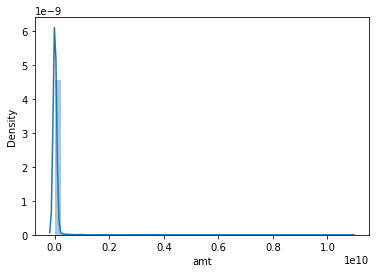

In [40]:
import seaborn as sns
sns.distplot(df_all['amt'])
df_all['amt'].describe()

In [43]:
#get the quantile list across all losses across all states
q_list = [0.25, 0.5, 0.75, 0.99] 
L_list = []

for q in q_list: 
    L_list.append(df_all.amt.quantile(q).round())
    
L_list

[63365.0, 588080.0, 3602530.0, 305316505.0]

In [49]:
#count number of years over certain percentile flooding risks historically 
state_list = base.keys()
risk = pd.DataFrame(index = state_list, columns= L_list)

for state in state_list: 
    for L in L_list: 
        #get one state amount 
        df1 =base[state][['year','amt']] 
        #compute frequency of years passing through threshold  
        freq = df1.loc[df1['amt']>=L].shape[0]/df1.shape[0]
        risk.loc[state][L] = freq


In [52]:
risk
# risk.to_csv('risk.csv')

,63365.0,588080.0,3602530.0,305316505.0
MD,0.770833,0.5,0.270833,0.0
MT,0.333333,0.0625,0.020833,0.0
TX,0.958333,0.9375,0.854167,0.125
FL,0.916667,0.895833,0.729167,0.104167
SC,0.875,0.645833,0.25,0.020833
VA,0.958333,0.729167,0.354167,0.0
MI,0.854167,0.5,0.208333,0.0
NC,0.958333,0.895833,0.541667,0.020833
NJ,0.958333,0.833333,0.520833,0.0625
OH,0.958333,0.791667,0.395833,0.0


year           2.017300e+03
amt            3.527163e+08
cma            3.602572e+08
sma            1.140310e+09
p_cma          3.609419e+08
p_sma          1.140318e+09
balance_cma   -9.004100e+07
balance_sma   -2.288508e+08
Name: 0.9, dtype: float64

In [55]:
base['FL'].quantile(0.9)

year           2.017300e+03
amt            2.735497e+08
cma            9.827977e+07
sma            1.909139e+08
p_cma          9.166605e+07
p_sma          1.901617e+08
balance_cma   -1.189069e+07
balance_sma   -6.830432e+07
Name: 0.9, dtype: float64

In [50]:
risk

,0.25,0.50,0.75,0.90
MD,0.75,0.5,0.25,0.104167
MT,0.75,0.5,0.25,0.104167
TX,0.75,0.5,0.25,0.104167
FL,0.75,0.5,0.25,0.104167
SC,0.75,0.5,0.25,0.104167
VA,0.75,0.5,0.25,0.104167
MI,0.75,0.5,0.25,0.104167
NC,0.75,0.5,0.25,0.104167
NJ,0.75,0.5,0.25,0.104167
OH,0.75,0.5,0.25,0.104167
